## Network Structure and the Effectiveness of Crowd Based Requirements Processes

Title: Network Structure and the Effectiveness of Crowd Based Requirements Processes

Autors: M. Robinson, S. Sarkani and M. Mazzuchi

Affiliation: School of Engineering and Applied Science, George Washington University

Abstract: In recent years, researchers have argued that crowd sourcing generates better requirements by eliciting feedback from a broader range of stakeholders. Proposed benefits of crowd-based requirements process include a higher volume of requirements reflecting a broader array of use cases and a more engaged and committed user base. Researchers cite the inability of project teams to effectively manage an overwhelming volume of crowd-sourced system requirements as a possible drawback. Using a data set consisting of project management artifacts from 562 open source software projects, this paper uses generalized linear models to analyze how system performance varies as the percentage of requirements sourced from the crowd increases with respect to five measures of effectiveness: the average requirement close-out and response times, the average comment activity on requirements, the average number of issues per crowd member, and the average volume of requirements over time. Additionally, the models measure how the impact of additional crowd engagement changes with stakeholder network structure. For each measure of effectiveness except issues per crowd member, the analysis shows that the effect of increasing crowd engagement changes depending on the structure of the stakeholder network and the percentage of requirements sourced from the crowd. The results imply stakeholder networks with multiple, disjoint hubs and a low level of localized clustering absorb additional crowd engagement most effectively and suggest that systems engineers who seek to employ crowd-based requirements processes should encourage contributors to specialize and develop processes to route incoming requirements to the appropriate specialist.

#### Table of Contents

1. [Introduction](#intro)
    1. [Input Data](#input_data)
    1. [Exploratory Data Analysis](#eda)
    1. [Network Variables](#network_vars)
    
    
2. [Regression Results](#regression_results)
    1. [Comment Activity](#average_comments)
    1. [Issue Volume](#issues_over_time)
    1. [Response Time](#avg_first_comment)
    1. [Issues Per User](#issues_per_user)
    1. [Close Out Time](#avg_active_time)

### Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from utils import glm_marginal_effect, compute_pca, calc_total_effect

## Part 1: Introduction <a id='intro'></a>

### Input Data <a id='input_data'></a>

The data for this project comes from GitHub and consists of project management data for 562 open source projects across five programming language. To ensure the project had enough data to build a coherent stakeholder network, only projects with over 30 requirements were considered. The list of packages for each language were sourced from curated lists of popular packages for each language, which are linked below. 

1. [JavaScript](https://github.com/sorrycc/awesome-javascript)
2. [Python](https://github.com/vinta/awesome-python)
3. [Java](https://github.com/akullpp/awesome-java)
4. [PHP](https://github.com/ziadoz/awesome-php)
5. [C++](https://github.com/fffaraz/awesome-cpp)

The data from the CSV file was aggregated after building the associated stakeholder networks. Aggregating this data requires access to the underlying contributor, issue and comment data from GitHub, which is too large to maintain in this repo. The logic for building the networks from the GitHub data can be found in the [`code/stakeholder_network.py`](https://github.com/MthwRobinson/sh-network-paper/blob/master/code/stakeholder_network.py). On request, the authors can provide a full Postgres SQL dump of the raw GitHub data.

In [3]:
data_file = os.path.join('..', 'github_data.csv')
data = pd.read_csv(data_file)

### Exploratory Data Analysis <a id='eda'></a>

We start off with some initial exploration of the data. First, we take a look at the distribution of crowd sourcing within the data set. As the histogram shows, the projects have a broad range of crowd sourcing intensity. This is good for our analysis because the data set captures a diversity of crowd sourcing behaviors.

(0.0, 1.0)

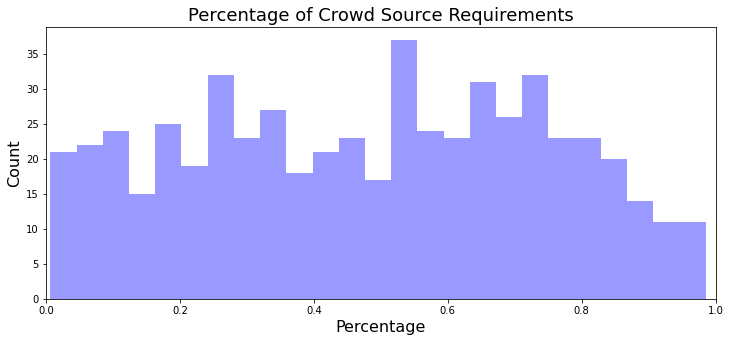

In [4]:
plt.figure(figsize=(12, 5))
sns.distplot(data['crowd_pct'], kde=False, color='blue', bins=25)
plt.title('Percentage of Crowd Source Requirements', fontsize=18)
plt.xlabel('Percentage', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 1])

Next we take a look at the distribution of a few of the variables in the data set. These are not the variables of interest, but are variables we intend to include in the analysis as controls. First we take a look at project age, which is normally distributed across the data set and ranges from a little over one year to ten years. It's worth noting that there are not many "young" projects because (1) it takes a project a while to gain enough popularity to be included in one of the curated lists and (2) limiting the data set to projects that have at least 30 requirements makes it harder for younger projects to make the cut.

(1.0, 10.0)

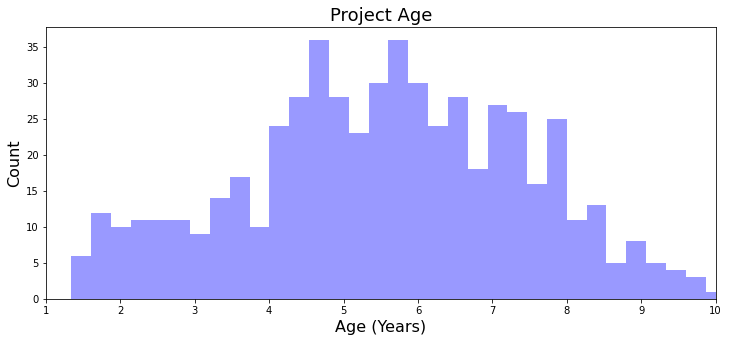

In [5]:
plt.figure(figsize=(12, 5))
sns.distplot(data['project_age']/365, kde=False, color='blue', bins=54)
plt.title('Project Age', fontsize=18)
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 10])

The next plot shows the total number of contributors in various project. Most projects have only a handful of contributors, although there's a long tail of projects with broader contributor bases. The data set considers anyone with a commit to be a contributor. As noted in the paper, this overestimates the number of project contributors because someone who submits only one pull request for a small fix isn't _truly_ a regular contributor to the project.

(1.0, 40.0)

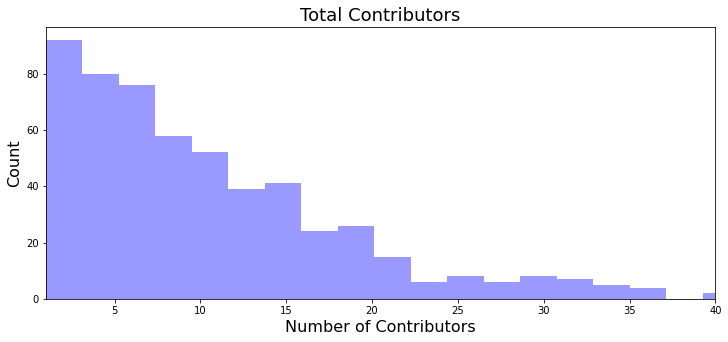

In [6]:
plt.figure(figsize=(12, 5))
sns.distplot(data['total_contributors'], kde=False, color='blue', bins=40)
plt.title('Total Contributors', fontsize=18)
plt.xlabel('Number of Contributors', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 40])

The next plot shows the distribution of stakeholders across the data set. Stakeholders consist of both contributors and crowd members. As we would expect, the number of stakeholders exceeds the number of contributors for a project. Although it is still left skewed, the number of stakeholders does not fall off as quickly as the number of contributors.

(30.0, 1000.0)

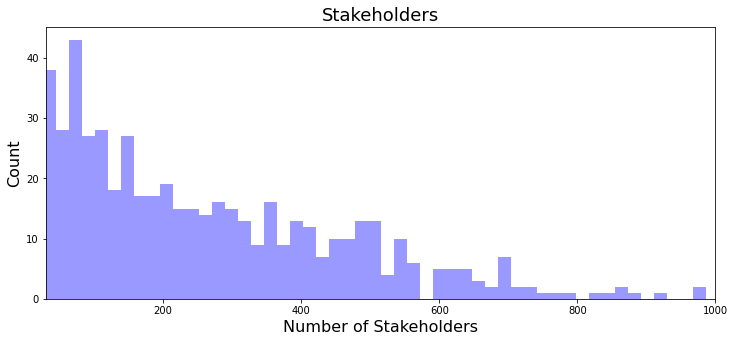

In [13]:
plt.figure(figsize=(12, 5))
sns.distplot(data['nodes'], kde=False, color='blue', bins=100)
plt.title('Stakeholders', fontsize=18)
plt.xlabel('Number of Stakeholders', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([30, 1000])

Finally, we provide a summary of the distribution for each of these variable.

In [14]:
data[['crowd_pct', 'project_age', 'total_contributors', 'nodes']].describe()

,crowd_pct,project_age,total_contributors,nodes
count,562.000000,562.000000,562.000000,562.000000
mean,0.480865,2030.005338,11.539146,274.754448
std,0.263940,708.745193,10.587185,253.108116
min,0.006711,488.000000,1.000000,7.000000
25%,0.265306,1586.000000,5.000000,83.250000
50%,0.500000,2049.000000,9.000000,209.000000
75%,0.699603,2546.750000,15.000000,398.250000
max,0.985294,5742.000000,86.000000,1891.000000


### Network Variables <a id='network_vars'></a>

For our next step, we want to see how the network structure variables relate to the crowd sourcing. We want to find out how these variables are correlated because if crowd sourcing only occurs in networks with a certain structure, it would be hard to determing whether crowd sourcing or network structure was driving changes in project management effectiveness.

We start out by plotting crowd sourcing against Gini coefficient, which is a measure of network concentration. As we can see, crowd sourcing is very evently distributed across the full range of values for Gini coefficients, which is a good property for our statistical analysis.

(0.0, 1.0)

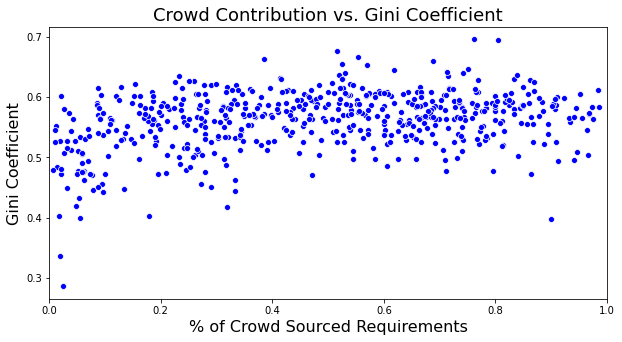

In [15]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['crowd_pct'], y=data['gini_coefficient'], color='blue')
plt.title('Crowd Contribution vs. Gini Coefficient', fontsize=18)
plt.xlabel('% of Crowd Sourced Requirements', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)
plt.xlim([0,1])

Next, we take a look at average minimum path, with is a measure of network breadth. The plot shows that broader networks more often occur in conjunction with more crowd sourcing. However, we see that crowd sourcing occurs even for relatively narrow networks. Again, this plot is encouraging for our research aims.

(0.0, 1.0)

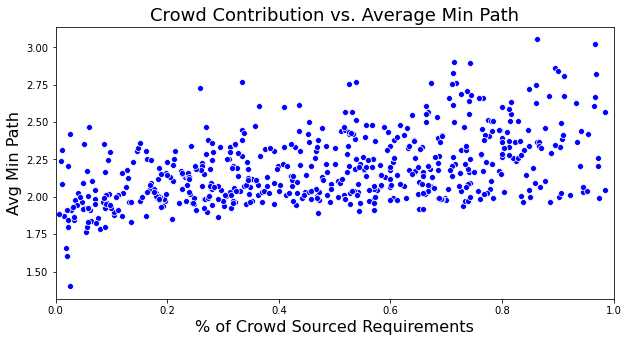

In [16]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['crowd_pct'], y=data['avg_min_path'], color='blue')
plt.title('Crowd Contribution vs. Average Min Path', fontsize=18)
plt.xlabel('% of Crowd Sourced Requirements', fontsize=16)
plt.ylabel('Avg Min Path', fontsize=16)
plt.xlim([0,1])

Finally, we take plot crowd sourcing against the clustering coefficient, which is a measuring of localized clustering in the network. Again we see a relative even spread of crowd sourcing acorss network structures, which is the statistical property we want for our analysis.

Text(0, 0.5, 'Clustering Coef.')

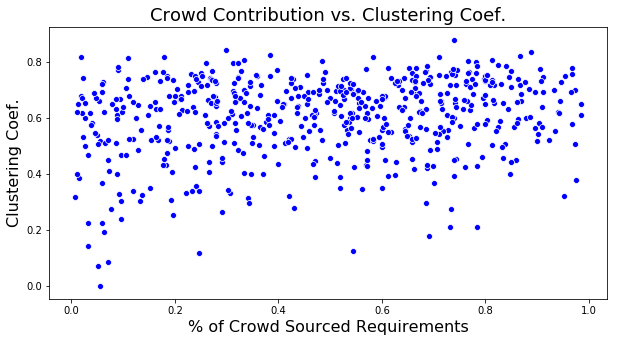

In [14]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['crowd_pct'], y=data['avg_clustering'], color='blue')
plt.title('Crowd Contribution vs. Clustering Coef.', fontsize=18)
plt.xlabel('% of Crowd Sourced Requirements', fontsize=16)
plt.ylabel('Clustering Coef.', fontsize=16)
plt.xlim([0,1])

We wrap up by summarizing the distribution of these variables. All in all, the initial exploration of the network structure reveals distributional properties which are encouraging for the proposed statistical analysis.

In [15]:
data[['gini_coefficient', 'avg_min_path', 'avg_clustering']].describe()

,gini_coefficient,avg_min_path,avg_clustering
count,562.000000,562.000000,562.000000
mean,0.561907,2.187393,0.601003
std,0.048177,0.232263,0.140855
min,0.285714,1.400000,0.000000
25%,0.535522,2.012390,0.522477
50%,0.568641,2.145767,0.627541
75%,0.592101,2.331743,0.704530
max,0.696200,3.054147,0.878524


## Regression Results <a id='regression_results'></a>

### Comment Activity <a id='average_comments'></a>

(1, 8)

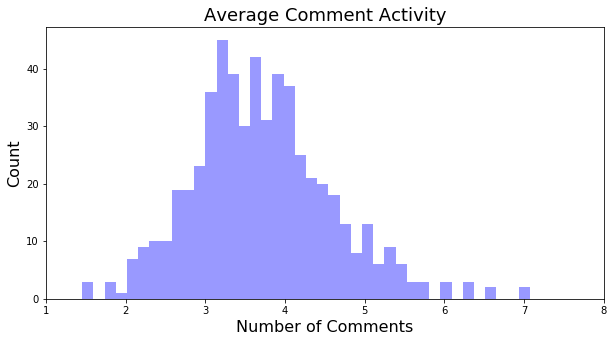

In [16]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Average Comment Activity', fontsize=18)
plt.xlabel('Number of Comments', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 8])

In [17]:
data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [18]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age +
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    topic_0:topic_1 + topic_0:topic_7 + topic_0:topic_9 + topic_0:topic_10 + 
    topic_0:topic_18 + topic_0:topic_19 + topic_0:topic_21 + 
    topic_1:topic_2 + topic_1:topic_9 + topic_1:topic_10 + topic_1:topic_13 + 
    topic_1:topic_14 + topic_1:topic_21 + topic_2:topic_11 + 
    topic_2:topic_12 + topic_2:topic_18 + topic_2:topic_20 + 
    topic_2:topic_22 + topic_3:topic_5 + topic_3:topic_11 + topic_3:topic_21 + 
    topic_4:topic_8 + topic_4:topic_18 + topic_5:topic_7 + topic_5:topic_9 + 
    topic_5:topic_11 + topic_5:topic_15 + topic_5:topic_17 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_8 + topic_6:topic_12 + 
    topic_6:topic_14 + topic_6:topic_16 + topic_6:topic_17 + 
    topic_6:topic_18 + topic_6:topic_19 + topic_7:topic_8 + topic_7:topic_16 + 
    topic_7:topic_23 + topic_8:topic_9 + topic_8:topic_15 + topic_9:topic_10 + 
    topic_9:topic_16 + topic_9:topic_19 + topic_9:topic_20 + 
    topic_9:topic_22 + topic_10:topic_12 + topic_10:topic_16 + 
    topic_10:topic_20 + topic_10:topic_22 + topic_10:topic_23 + 
    topic_11:topic_13 + topic_11:topic_14 + topic_11:topic_15 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_22 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_22 + 
    topic_15:topic_16 + topic_15:topic_18 + topic_15:topic_21 + 
    topic_16:topic_19 + topic_16:topic_22 + topic_17:topic_18 + 
    topic_17:topic_20 + topic_17:topic_22 + topic_18:topic_23 + 
    topic_19:topic_20 + topic_19:topic_21 + topic_19:topic_23 + 
    topic_20:topic_21 + topic_21:topic_22 + topic_3:topic_8 + 
    topic_7:topic_18 + topic_5:topic_12
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
# X = compute_pca(X, 80)
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-02-02 19:16:30,182 [626] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.



0.6302982537494449
112
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      450
Model Family:                   Gamma   Df Model:                          111
Link Function:                    log   Scale:                        0.033179
Method:                          IRLS   Log-Likelihood:                -498.74
Date:                Sun, 02 Feb 2020   Deviance:                       14.036
Time:                        19:16:31   Pearson chi2:                     14.9
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

(1, 8)

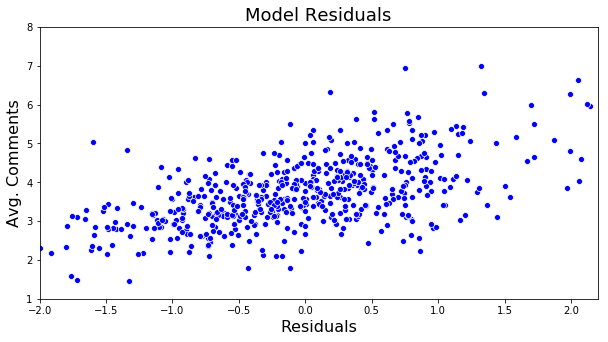

In [24]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_comments'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Avg. Comments', fontsize=16)
plt.xlim([-2, 2.2])
plt.ylim([1, 8])

(-2.2, 2.2)

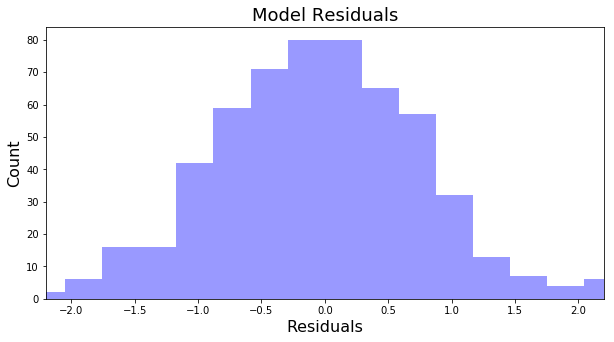

In [31]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=30)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.2, 2.2])

In [44]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 2.2219055240255807
avg_min_path: -1.7476539457592113
gini_coefficient: 4.32772542102624


In [45]:
calc_total_effect(data, res, X)

0.028131459759271244

Text(0.5, 0, 'Crowd Source Percentage')

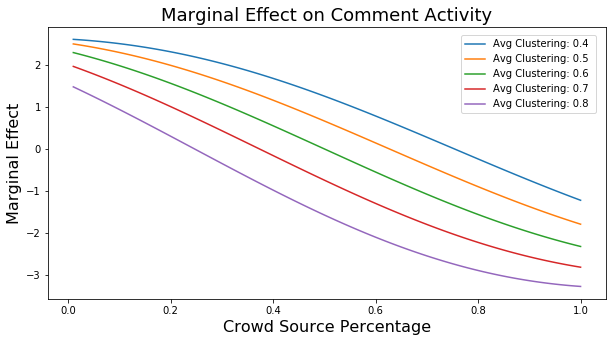

In [64]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.74, .97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

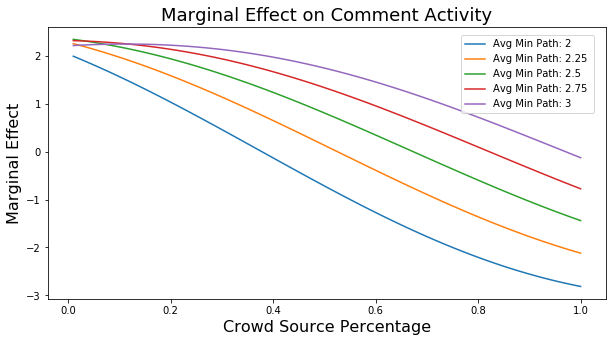

In [66]:
plt.figure(figsize=(10, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.74, .97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

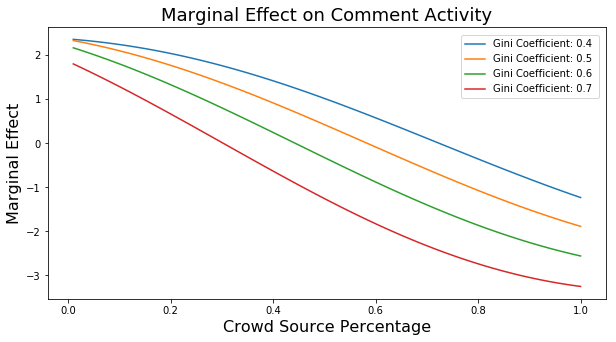

In [62]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = data['avg_clustering']
    avg_min_path = data['avg_min_path']

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.74, .97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Issue Volume <a id='issues_over_time'></a>

(1, 20)

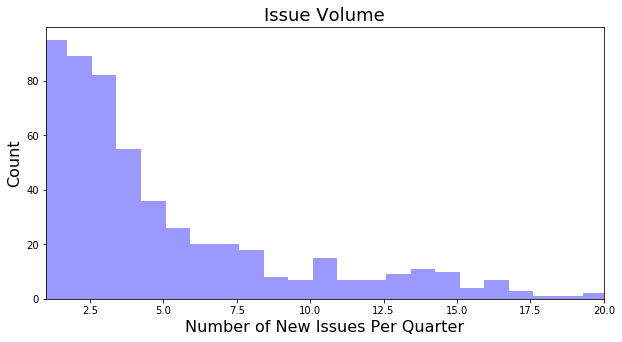

In [32]:
plt.figure(figsize=(10, 5))
sns.distplot(data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Issue Volume', fontsize=18)
plt.xlabel('Number of New Issues Per Quarter', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 20])

In [33]:
data['issues_over_time'].describe()

count    562.000000
mean       6.508193
std        8.301123
min        0.899700
25%        2.148635
50%        3.585452
75%        7.523364
max       84.420881
Name: issues_over_time, dtype: float64

In [34]:
formula = """
issues_over_time ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + total_contributors + 
    project_age
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-02-02 19:22:01,265 [626] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':



0.6608879631166316
11
                 Generalized Linear Model Regression Results                  
Dep. Variable:       issues_over_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      551
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                         0.39844
Method:                          IRLS   Log-Likelihood:                -1292.0
Date:                Sun, 02 Feb 2020   Deviance:                       168.93
Time:                        19:22:01   Pearson chi2:                     220.
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

(0, 25)

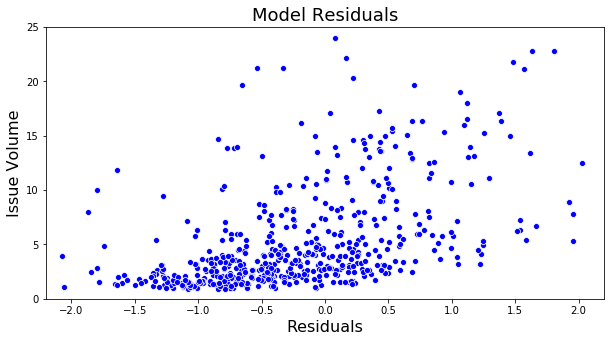

In [37]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['issues_over_time'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issue Volume', fontsize=16)
plt.xlim([-2.2, 2.2])
plt.ylim([0, 25])

(-2.2, 2.2)

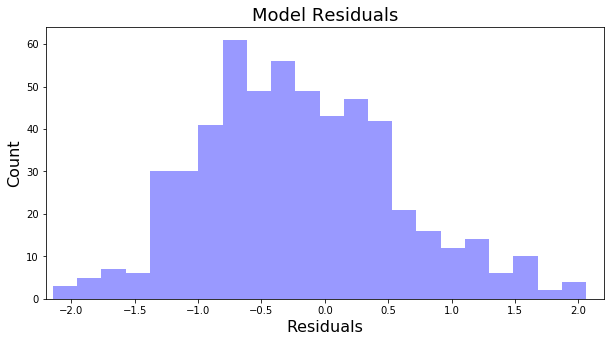

In [42]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=30)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.2, 2.2])

In [28]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

avg_clustering: -3.833244128274739
avg_min_path: -0.16296451670706222
gini_coefficient: 22.819708227746496


In [29]:
calc_total_effect(data, res, X)

-5.811775501937335

Text(0.5, 0, 'Crowd Source Percentage')

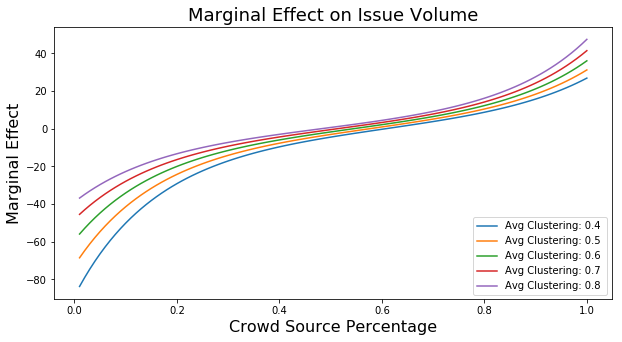

In [92]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.75, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Issue Volume', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Response Time <a id='avg_first_comment'></a>

In [94]:
data['avg_first_comment'].describe()

count    562.000000
mean      29.004449
std       37.018716
min        0.169014
25%        8.695482
50%       18.767917
75%       35.140768
max      389.746114
Name: avg_first_comment, dtype: float64

(0, 80)

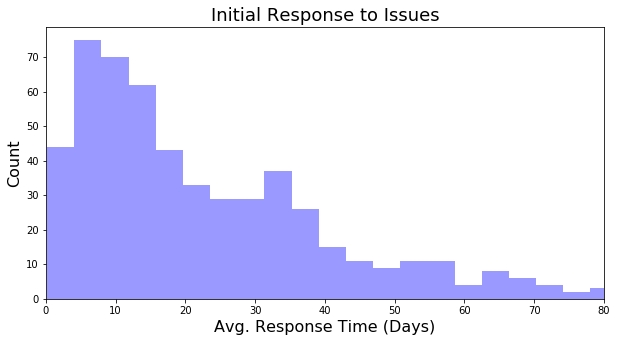

In [136]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_first_comment'], kde=False, color='blue', bins=100)
plt.title('Initial Response to Issues', fontsize=18)
plt.xlabel('Avg. Response Time (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 80])

In [77]:
formula = """
avg_first_comment ~ crowd_pct + crowd_pct_2 + avg_clustering +
    avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + gini_coefficient + gini_coefficientXcrowd_pct + 
    project_age 
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-02-02 19:43:11,215 [626] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.41131874532143486
9
                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_first_comment   No. Observations:                  562
Model:                            GLM   Df Residuals:                      553
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.77195
Method:                          IRLS   Log-Likelihood:                -2300.6
Date:                Sun, 02 Feb 2020   Deviance:                       352.76
Time:                        19:43:11   Pearson chi2:                     427.
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

(0, 150)

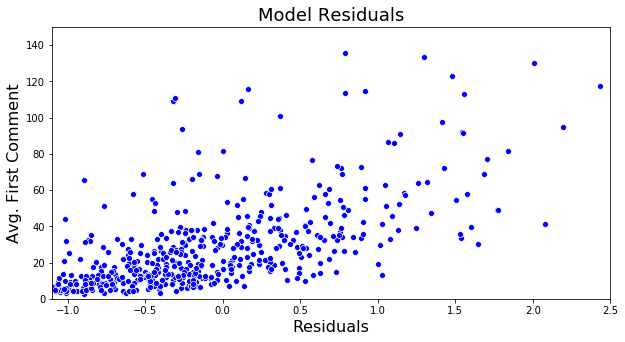

In [74]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_first_comment'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Avg. First Comment', fontsize=16)
plt.xlim([-1.1, 2.5])
plt.ylim([0, 150])

(-1.1, 2.5)

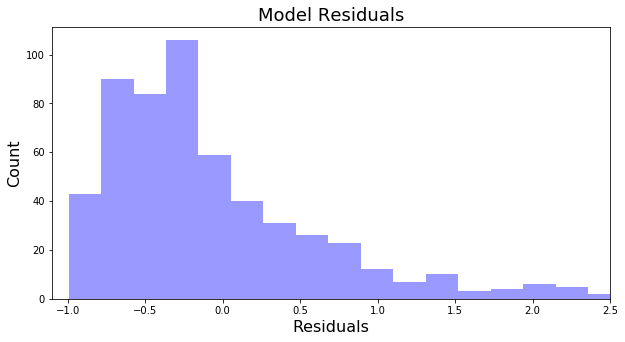

In [76]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_pearson, kde=False, color='blue', bins=50)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-1.1, 2.5])

In [78]:
network_factors = ['avg_clustering', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 25.329832696919183
gini_coefficient: -179.0928630010859


In [126]:
calc_total_effect(data, res, X)

8.3466691229711

Text(0.5, 0, 'Crowd Source Percentage')

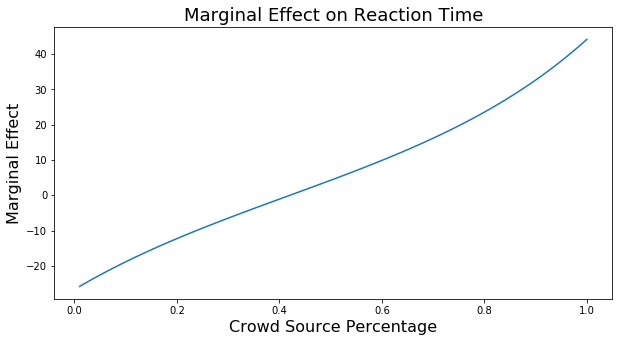

In [138]:
plt.figure(figsize=(10, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.title('Marginal Effect on Reaction Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

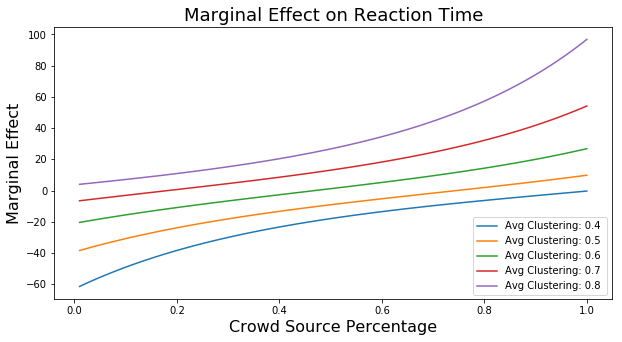

In [139]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.75, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Reaction Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

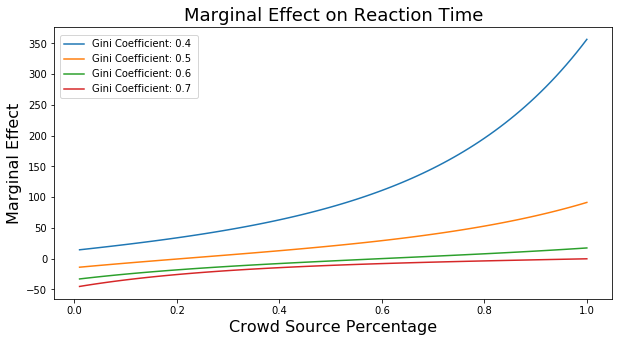

In [140]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Reaction Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Issues Per User <a id='issues_per_user'></a>

In [16]:
data['issues_per_user'].describe()

count    562.000000
mean       5.422194
std        8.544846
min        1.113402
25%        2.192618
50%        3.177866
75%        5.174578
max       97.000000
Name: issues_per_user, dtype: float64

(1, 20)

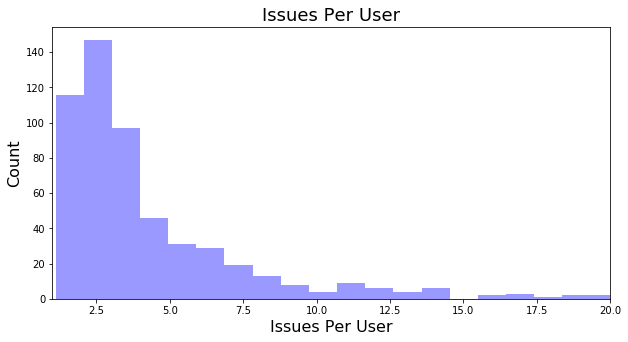

In [79]:
plt.figure(figsize=(10, 5))
sns.distplot(data['issues_per_user'], kde=False, color='blue', bins=100)
plt.title('Issues Per User', fontsize=18)
plt.xlabel('Issues Per User', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 20])

In [50]:
formula = """
issues_per_user ~ crowd_pct + crowd_pct_2 + avg_min_path + 
    gini_coefficient + gini_coefficientXcrowd_pct 
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-02-02 19:28:29,712 [626] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  import sys



0.645577627340495
6
                 Generalized Linear Model Regression Results                  
Dep. Variable:        issues_per_user   No. Observations:                  562
Model:                            GLM   Df Residuals:                      556
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                         0.67543
Method:                          IRLS   Log-Likelihood:                -1284.5
Date:                Sun, 02 Feb 2020   Deviance:                       153.48
Time:                        19:28:29   Pearson chi2:                     376.
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------


(0, 25)

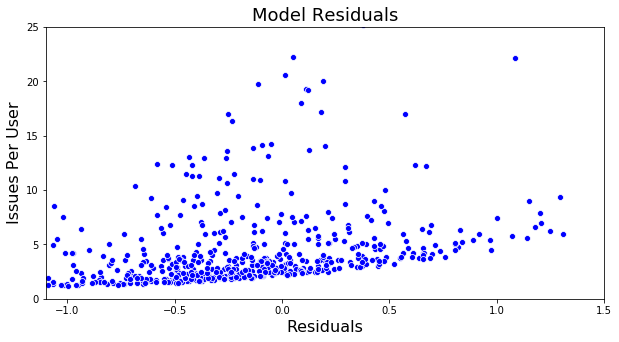

In [56]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['issues_per_user'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues Per User', fontsize=16)
plt.xlim([-1.1, 1.5])
plt.ylim([0, 25])

(-1.1, 1.5)

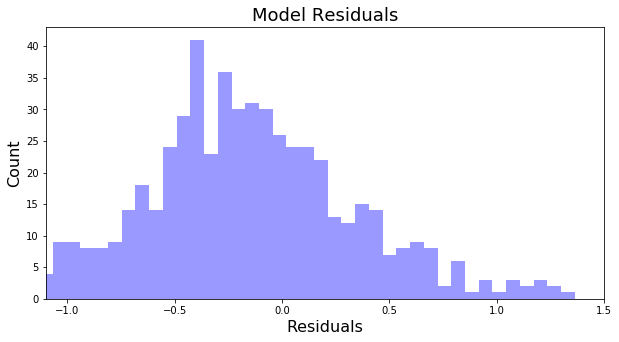

In [57]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=100)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-1.1, 1.5])

In [45]:
glm_marginal_effect('avg_min_path', res, X, data)

3.0108534148009145

In [46]:
calc_total_effect(data, res, X)

-19.11782332424723

In [81]:
8.29 / (2*6.19)

0.6696284329563812

### Close Out Time <a id='avg_active_time'></a>

In [88]:
data['avg_active_time'].describe()

count    562.000000
mean      68.128883
std       52.051931
min        0.675000
25%       31.744782
50%       55.716894
75%       88.387924
max      531.482618
Name: avg_active_time, dtype: float64

(1, 200)

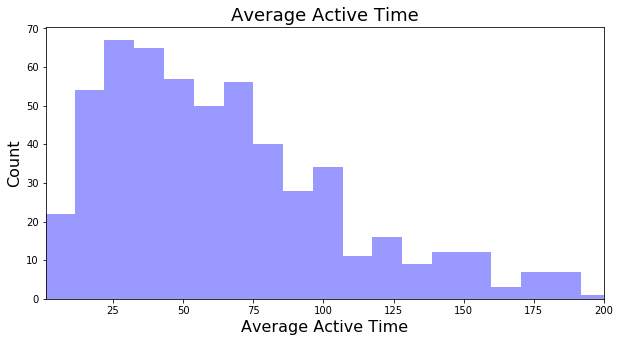

In [89]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_active_time'], kde=False, color='blue', bins=50)
plt.title('Average Active Time', fontsize=18)
plt.xlabel('Average Active Time', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 200])

In [102]:
formula = """
avg_active_time ~ crowd_pct + avg_min_path + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age + 
    nodes + avg_clustering + gini_coefficient
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-02-02 22:08:20,212 [626] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  



0.513893531085627
10
                 Generalized Linear Model Regression Results                  
Dep. Variable:        avg_active_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      552
Model Family:                   Gamma   Df Model:                            9
Link Function:                    log   Scale:                         0.29995
Method:                          IRLS   Log-Likelihood:                -2661.0
Date:                Sun, 02 Feb 2020   Deviance:                       151.16
Time:                        22:08:20   Pearson chi2:                     166.
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

(0, 250)

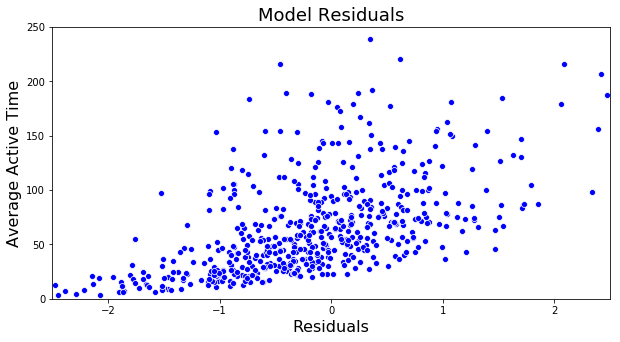

In [103]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_active_time'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Average Active Time', fontsize=16)
plt.xlim([-2.5, 2.5])
plt.ylim([0, 250])

(-2.5, 2.5)

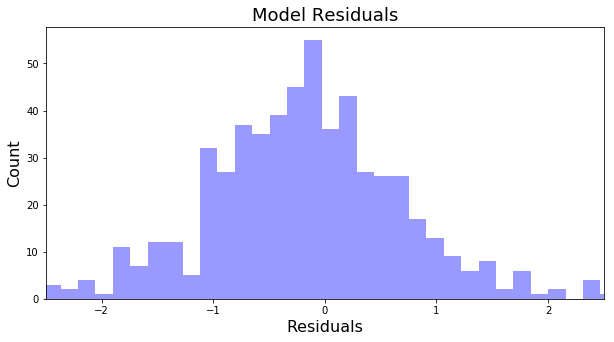

In [92]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=50)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.5, 2.5])

In [93]:
network_factors = ['avg_clustering', 'avg_min_path', 'gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 121.66307997277427
avg_min_path: 2.9060877586452
gini_coefficient: -201.7668919374362


In [94]:
calc_total_effect(data, res, X)

49.258193475816284

Text(0.5, 0, 'Crowd Source Percentage')

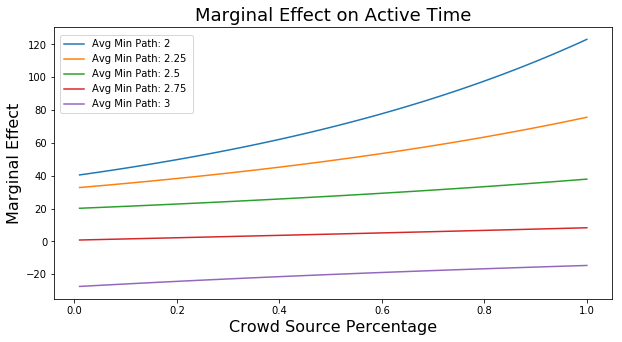

In [98]:
plt.figure(figsize=(10, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Active Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

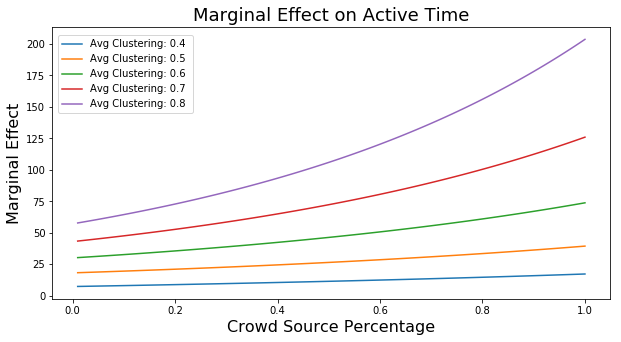

In [99]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Active Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

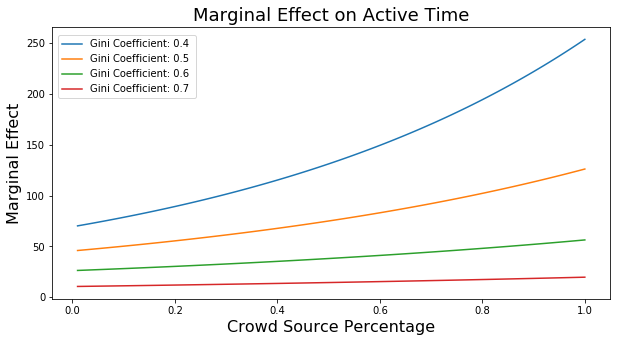

In [100]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Active Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)